In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import tensorflow as tf
import seaborn as sns

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Setar o valor semente para a reprodutibilidade do experimento. 
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
DATASET_PATH = 'C:\\Users\\kevin\\Desktop\\Dogs&Cats\\cats_dogs'

files_dir = os.listdir(DATASET_PATH)

In [3]:
cats = []
dogs = []
for i in range(len(files_dir)):
    animal, _ = files_dir[i].split('_',1)
    if animal == 'cat':
        cats.append(files_dir[i])
    else:
        dogs.append(files_dir[i])
        
train_files_ = []
for i in range(110):
    q = i % 2
    if q == 0:
        train_files_.append(cats[i])
    else:
        train_files_.append(dogs[i])
a = []
for i in range(len(train_files_)):
    a.append(str('C:\\Users\\kevin\\Desktop\\Dogs&Cats\\cats_dogs\\' + train_files_[i]))

In [4]:
print('Number total of cats: ' + str(len(cats)))
print('Number total of dogs: ' + str(len(dogs)))

Number total of cats: 164
Number total of dogs: 113


In [5]:
label_catdog = ['cat','dog']

In [6]:
from sklearn.model_selection import train_test_split
train_cat, test_cat, test_dog, train_dog = train_test_split(cats[:100],dogs[:100],test_size=0.3,random_state=42)

train_files = train_cat + train_dog
test_files = test_cat + test_dog

In [7]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    return tf.squeeze(audio,axis=-1)

In [8]:
def get_label(file_path):
    _, s = a[0].split('C:\\Users\\kevin\\Desktop\\Dogs&Cats\\cats_dogs\\')
    parts = tf.strings.split(input=s,sep='_')
    return parts[-2]

In [9]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds  = tf.data.Dataset.from_tensor_slices(a)

waveform_ds = files_ds.map(map_func=get_waveform_and_label,num_parallel_calls=AUTOTUNE)

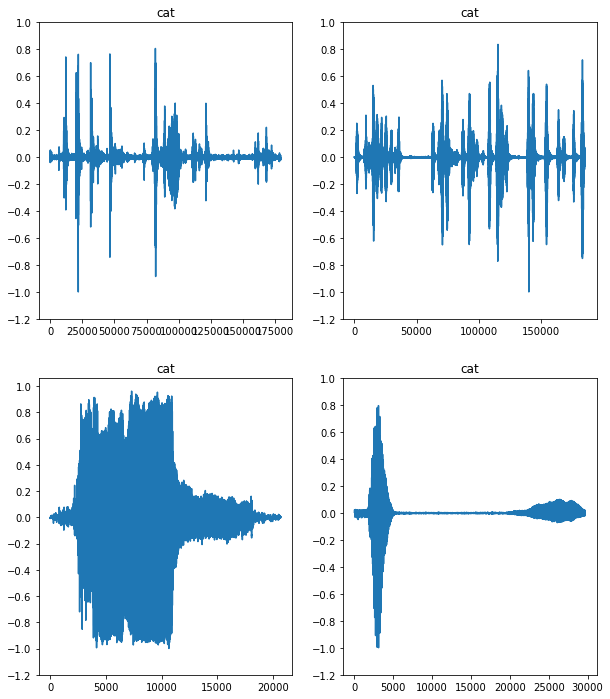

In [11]:
rows = 2
cols = 2
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [12]:
def get_spectrogram(waveform):
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  waveform = tf.cast(waveform, dtype=tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [13]:
for waveform, label in waveform_ds.take(0):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: cat


NameError: name 'waveform' is not defined

In [14]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

NameError: name 'waveform' is not defined

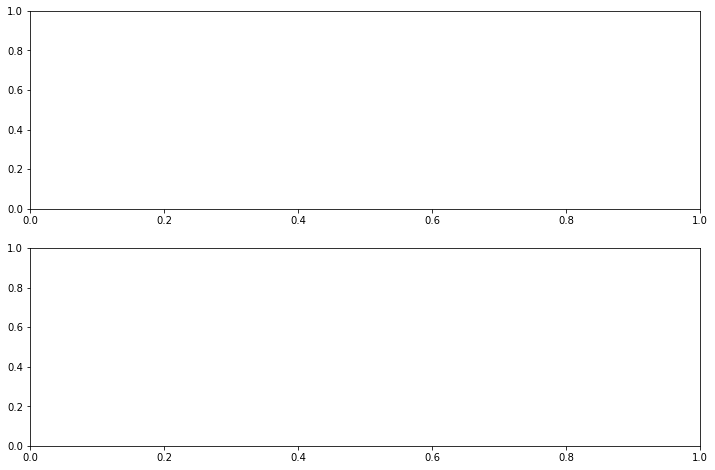

In [15]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == label_catdog)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(map_func=get_spectrogram_and_label_id,num_parallel_calls=AUTOTUNE)

In [ ]:
spectrogram_ds

In [ ]:
rows = 2
cols = 2
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(label_catdog[label_id.numpy()])
  ax.axis('off')

plt.show()

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
b = []
for i in range(len(train_files)):
    b.append(str('C:\\Users\\kevin\\Desktop\\Dogs&Cats\\cats_dogs\\' + train_files[i]))
train_ds = spectrogram_ds
val_ds = preprocess_dataset(a)
test_ds = preprocess_dataset(b)

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(label_catdog)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

In [ ]:

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_catdog,
            yticklabels=label_catdog,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()